In [1]:
import sys
sys.path.append('../')
import sqlutilpy
from config import configuration
config = configuration()
config.request_password()


 ·············


In [2]:
import glob
file_loc = \
'/local/scratch_2/jls/virac_classifier/results_compiled/uhhpc.herts.ac.uk/'+\
'~lsmith/for_jason/virac_classifier/results/*.gz'
results = pd.concat([pd.read_csv(f) for f in glob.glob(file_loc)])

In [3]:
def cutout(x):
    sid = 0.9972695667
    yr=365.25
    tol = 2.5e-4
    fltr = [True] * len(x)
    for frac in range(2,10):
        fltr &= ~((1./x['lsq_period']>frac/sid-tol)&(1./x['lsq_period']<frac/sid+tol))
        fltr &= ~((1./x['lsq_period']>frac/sid+1./yr-tol)&(1./x['lsq_period']<frac/sid+1./yr+tol))
        fltr &= ~((1./x['lsq_period']>frac/sid-1./yr-tol)&(1./x['lsq_period']<frac/sid-1./yr+tol))
    return fltr

results_c = results[cutout(results)].reset_index(drop=True)

In [4]:
def period_fix(var_in,tol=1.):

    period_out = var_in['lsq_period'].values.copy()

    period_out[((var_in['class']=='EA/EB')|(var_in['class']=='Ell'))&
                (var_in['amp_0']>tol*var_in['amp_1'])]*=2.
    
    ss=np.argmax([var_in['amp_0'].values,
                  var_in['amp_1'].values,
                  var_in['amp_2'].values,
                  var_in['amp_3'].values],axis=0)
    fltr = ~((var_in['class']=='EA/EB')|(var_in['class']=='Ell'))
    period_out[fltr]/=(1.+ss)[fltr]
    
    period_out[var_in['class']=='EW']*=2
    
    return period_out
    
results_c['period'] = period_fix(results_c)

In [5]:
results_c_fap = results_c[results_c['class']!='CONST'].reset_index(drop=True)

In [144]:
def relabel_table_first(data):
    
    col32_save = [
        'amp_0', 'amp_1', 'amp_2', 'amp_3', 
        'amp_double_0', 'amp_double_1', 'amp_double_2', 'amp_double_3', 
        'amplitude', 'beyondfrac', 'delta_loglik',  'log10_fap',
        'lsq_period_error', 'max_pow', 'max_phase_lag', 'pow_mean_disp', 'phase_lag_mean',
        'phi_0','phi_1','phi_2','phi_3',
        'phi_double_0','phi_double_1','phi_double_2','phi_double_3',           
        'peak_ratio_model', 'peak_ratio_data',
        'JK_col','HK_col','prob', 'prob_1st_stage','prob_nofap','prob_var','prob_var_nofap',
        'Z_scale','Z_model','Y_scale','Y_model','J_scale','J_model','H_scale','H_model',
        'model_amplitude'
    ]

    save_cols_types = dict(zip(col32_save,[np.float32]*len(col32_save)))
    data = data.astype(save_cols_types)
    save_cols_types = {'n_epochs':np.int16, 'lsq_nterms':np.int16 }
    data = data.astype(save_cols_types)
    
    for c in data.columns[data.columns.str.contains('pspl')]:
        del data[c]
    for c in data.columns[data.columns.str.contains('ncross')]:
        del data[c]
    data = data.rename(columns={c:c+'_factor' for c in data.columns[data.columns.str.contains('_scale')]})
    for s in ['phi','amp','phi_double','amp_double']:
        for ii in [4,3,2,1]:
            data = data.rename(columns={s+'_%i'%(ii-1):'lsq_'+s+'_%i'%ii})

    data = data.rename(columns = {c: '_'.join(c.split('_b_')) 
                                 for c in data.columns[data.columns.str.contains('_b_')]})
    data = data.rename(columns = {'peak_ratio_model': 'ks_consec_minimum_ratio_model',
                                  'peak_ratio_data': 'ks_consec_minimum_ratio_data'})
    data = data.rename(columns={'amplitude':'ks_amplitude',
                                'chisq':'astfit_chisq',
                                'uwe':'astfit_uwe',
                                'delta_loglik':'delta_logl_lsq_const',
                                'beyondfrac':'ks_frac_detections_outside_1sigma',
                                'max_pow':'lombscargle_max_pow',
                                'max_phase_lag':'ks_phasediff_max',
                                'phase_lag_mean':'ks_phasediff_max_dev_std_ratio',
                                'pow_mean_disp':'lombscargle_pow_max_dev_std_ratio',
                                'n_epochs':'ks_lsq_n_epochs',
                                'ks_n_epochs':'ks_varstats_n_epochs',
                                'ks_stdev':'ks_std_varstats',
                                'log10_fap':'log10_lombscargle_fap',
                                'model_amplitude':'ks_lsq_amplitude'})
    data.columns = map(str.lower, data.columns)
    data = data.rename(columns={ii+'_model':ii+'_rms_ks_rms_ratio' for ii in ['z','y','j','h']})
    data = data.rename(columns={'jk_col':'j_ks_0', 'hk_col':'h_ks_0'})
    return data

In [7]:
import sqlutilpy
rr=pd.DataFrame(sqlutilpy.get('''select * from jason_sanders.virac2_variables_v0_1''', **config.wsdb_kwargs))

In [145]:
results_c_fap_relabelled = relabel_table_first(results_c_fap)

In [146]:
set(results_c_fap_relabelled.columns)-set(rr.columns)

{'class_nofap', 'h_ks_0', 'j_ks_0', 'prob_nofap', 'prob_var', 'prob_var_nofap'}

In [147]:
rr['previous']=1
cols = list(set(rr.columns)-set(results_c_fap_relabelled.columns))+['sourceid']
r_extra_c_fap = pd.merge(results_c_fap_relabelled, rr[cols], on='sourceid', how='left')

In [252]:
combined_dset_previous_sid = pd.merge(results_c_fap_relabelled[['sourceid']], rr[['sourceid','previous']], on='sourceid', how='left') # r_extra_c_fap[r_extra_c_fap['previous']==1]

combined_dset_previous = pd.merge(results_c_fap_relabelled[combined_dset_previous_sid['previous']==1].reset_index(drop=True), rr[cols], on='sourceid', how='left') # r_extra_c_fap[r_extra_c_fap['previous']==1]
del combined_dset_previous['previous']

In [11]:
r_not_previous = r_extra_c_fap[r_extra_c_fap['previous']!=1].reset_index(drop=True)

In [29]:
combined_dset=sqlutilpy.local_join('''
select t.sourceid,
v.astfit_epochs,v.astfit_params,v.duplicate,v.ref_epoch,v.ra,v.ra_error,v.dec,v.dec_error,v.parallax,
v.parallax_error,v.pmra,v.pmra_error,v.pmdec,v.pmdec_error,v.ra_dec_corr,v.ra_parallax_corr,v.ra_pmra_corr,
v.ra_pmdec_corr,v.dec_parallax_corr,v.dec_pmra_corr,v.dec_pmdec_corr,v.parallax_pmra_corr,v.parallax_pmdec_corr,
v.pmra_pmdec_corr,v.chisq,v.uwe,v.z_n_detections,v.z_n_observations,v.z_n_ambiguous,v.y_n_detections,v.y_n_observations,
v.y_n_ambiguous,v.j_n_detections,v.j_n_observations,v.j_n_ambiguous,v.h_n_detections,v.h_n_observations,v.h_n_ambiguous,
v.ks_n_detections,v.ks_n_observations,v.ks_n_ambiguous,v.ivw_mean_contemp_j_ks,v.ivw_mean_contemp_h_ks,v.l,v.b,
m.z_b_med_mag,m.z_b_mean_mag,m.z_b_ivw_mean_mag,m.z_b_std_mag,m.z_b_mad_mag,m.z_b_ivw_err_mag,m.z_n_b_phot,
m.y_b_med_mag,m.y_b_mean_mag,m.y_b_ivw_mean_mag,m.y_b_std_mag,m.y_b_mad_mag,m.y_b_ivw_err_mag,m.y_n_b_phot,
m.j_b_med_mag,m.j_b_mean_mag,m.j_b_ivw_mean_mag,m.j_b_std_mag,m.j_b_mad_mag,m.j_b_ivw_err_mag,m.j_n_b_phot,
m.h_b_med_mag,m.h_b_mean_mag,m.h_b_ivw_mean_mag,m.h_b_std_mag,m.h_b_mad_mag,m.h_b_ivw_err_mag,m.h_n_b_phot,
m.ks_b_med_mag,m.ks_b_mean_mag,m.ks_b_ivw_mean_mag,m.ks_b_std_mag,m.ks_b_mad_mag,m.ks_b_ivw_err_mag,m.ks_n_b_phot,
n.ks_n_epochs,n.ks_mean,n.ks_stdev,n.ks_kurtosis,n.ks_skew,n.ks_p0,n.ks_p1,n.ks_p2,n.ks_p4,n.ks_p5,n.ks_p8,
n.ks_p16,n.ks_p25,n.ks_p32,n.ks_p50,n.ks_p68,n.ks_p75,n.ks_p84,n.ks_p92,n.ks_p95,n.ks_p96,n.ks_p98,n.ks_p99,
n.ks_p100,n.ks_mad,n.ks_epoch_first,n.ks_epoch_last,n.ks_eta,n.ks_eta_e,n.ks_stetson_in,n.ks_stetson_i,
n.ks_stetson_j,n.ks_stetson_k,n.ks_ncross_m10_std,n.ks_ncross_m5_std,n.ks_ncross_m3_std,n.ks_ncross_m2_std,
n.ks_ncross_m1_std,n.ks_ncross_0_std,n.ks_ncross_1_std,n.ks_ncross_2_std,n.ks_ncross_3_std,n.ks_ncross_5_std,
n.ks_ncross_10_std,n.ks_ncross_m10_mad,n.ks_ncross_m5_mad,n.ks_ncross_m3_mad,n.ks_ncross_m2_mad,n.ks_ncross_m1_mad,
n.ks_ncross_0_mad,n.ks_ncross_1_mad,n.ks_ncross_2_mad,n.ks_ncross_3_mad,n.ks_ncross_5_mad,n.ks_ncross_10_mad
from t
inner join leigh_smith.virac2 as v on t.sourceid=v.sourceid
left join leigh_smith.virac2_photstats as m on t.sourceid=m.sourceid
inner join leigh_smith.virac2_var_indices as n on t.sourceid=n.sourceid
order by t.xid''',
't',[np.int64(r_not_previous['sourceid'].values),np.arange(len(r_not_previous)),],['sourceid','xid',],**config.wsdb_kwargs)

In [152]:
def relabel_combined(data):
    
    data = data.rename(columns = {c: '_'.join(c.split('_b_')) 
                                 for c in data.columns[data.columns.str.contains('_b_')]})
    
    data = data.rename(columns={'chisq':'astfit_chisq',
                                'uwe':'astfit_uwe',
                                'ks_n_epochs':'ks_varstats_n_epochs',
                                'ks_stdev':'ks_std_varstats',
                                'jk_col':'j_ks_0',
                                'hk_col':'h_ks_0'})
    del data['duplicate']
    del data['ks_mean']
    del data['astfit_params']
    for c in data.columns[data.columns.str.contains('ncross')]:
        del data[c]
    
    data.insert(51,'ejk_rc',data['j_ivw_mean_mag']-data['ks_ivw_mean_mag']-data['j_ks_0'])
    data.insert(52,'ehk_rc',data['h_ivw_mean_mag']-data['ks_ivw_mean_mag']-data['h_ks_0'])
    
    return data

combined_dset_pd = relabel_combined(pd.merge(pd.DataFrame(combined_dset),results_c_fap_relabelled[r_extra_c_fap['previous']!=1],on='sourceid'))

In [39]:
missing_sources = combined_dset_pd[combined_dset_pd['ks_b_mean_mag']!=combined_dset_pd['ks_b_mean_mag']].reset_index(drop=True)
missing_sources[['sourceid']].to_csv('/local/scratch_2/jls/virac_classifier/results/edr3_SJ_noalias/variables_missingsources.csv',index=False)

In [40]:
import sys
sys.path.append('../../../../')
from virac_utils import cm_gaia

gaia_dset_pd = cm_gaia(combined_dset_pd, epoch=2014.0, cm_radius=0.5, use_pm=True)

In [153]:
gaia_columns = ['source_id','ra','dec','parallax','pmra','pmdec',
                'parallax_error','pmra_error','pmdec_error',
                'parallax_pmra_corr','parallax_pmdec_corr','pmra_pmdec_corr',
                'phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag',
                'ruwe']

for c in gaia_columns:
    combined_dset_pd['gaia_edr3_'+c] = gaia_dset_pd[c]
combined_dset_pd['virac2_gedr3_sep'] = gaia_dset_pd['q3c_dist']
combined_dset_pd['ebv_schlegel'] = gaia_dset_pd['ebv']

In [254]:
full_data = pd.concat([combined_dset_previous, combined_dset_pd], axis=0, sort=False)
del full_data['j_ks_0']
del full_data['h_ks_0']
cc = rr.columns.copy()[:-1]
full_data = full_data[np.concatenate([cc,['class_nofap', 'prob_nofap', 'prob_var', 'prob_var_nofap']])]
full_data['sourceid']=full_data['sourceid'].astype(np.int64)
full_data['significant_second_minimum']=full_data['significant_second_minimum'].astype(bool)
full_data['ks_stetson_j']/=(full_data['ks_varstats_n_epochs']-1)

In [256]:
len(results_c_fap),len(gaia_dset_pd), len(combined_dset_pd), len(combined_dset_previous), len(full_data), len(np.unique(full_data.sourceid))

(1364732, 281863, 281863, 1082869, 1364732, 1364732)

In [205]:
set(rr.columns)-set(full_data.columns)

{'previous'}

In [173]:
set(full_data.columns)-set(rr.columns)

{'class_nofap', 'prob_nofap', 'prob_var', 'prob_var_nofap'}

In [191]:
import sys
sys.path.append('../../../../')
from virac_utils import wsdb_upload_kwargs, wsdb_kwargs

In [473]:
def fmtr(data,s,chunk):
    clss = ['class','class_nofap','ogle_type','ogle_id']
    if s in clss:
        return data[s].values.astype(str)[chunk[0]:chunk[1]]
    else:
        return data[s].values[chunk[0]:chunk[1]]

In [264]:
cT=True
for chunk in [[0,500000],[500000,1000000],[1000000,1500000]]:
    sqlutilpy.upload('virac2_variables',
                     [fmtr(full_data,s,chunk) for s in full_data.keys()],
                     full_data.keys(),createTable=cT,
                     **wsdb_upload_kwargs)
    cT=False

## Adding in the missing photometry

In [40]:
full_data = pd.DataFrame(sqlutilpy.get('''select * from jason_sanders.virac2_variables''', **config.wsdb_kwargs))

In [41]:
print(len(full_data))

1364732


In [42]:
print(np.count_nonzero(full_data['ks_ivw_mean_mag']!=full_data['ks_ivw_mean_mag']))

4185


In [6]:
extra_data = pd.DataFrame(sqlutilpy.get('''select * from leigh_smith.virac2_var_photstats''', **config.wsdb_kwargs))

In [43]:
extra_data_missing=extra_data[np.isin(extra_data['sourceid'],full_data['sourceid'][full_data['ks_ivw_mean_mag']!=full_data['ks_ivw_mean_mag']].values)]

In [44]:
extra_data_missing = extra_data_missing.rename(columns = {c: '_'.join(c.split('_b_')) 
                                 for c in extra_data_missing.columns[extra_data_missing.columns.str.contains('_b_')]})

In [45]:
indices=[np.argwhere(full_data['sourceid']==e)[0][0] for e in extra_data_missing['sourceid'].values]

/data/jls/python3.5/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


In [46]:
for c in extra_data_missing.columns:
    if c in ['sourceid', 'l', 'b']:
        continue
    full_data[c].iloc[indices] = extra_data_missing[c].values

In [48]:
np.count_nonzero(full_data['ks_ivw_mean_mag']!=full_data['ks_ivw_mean_mag'])

0

In [53]:
import sys
sys.path.append('../../../../')
from virac_utils import wsdb_upload_kwargs, wsdb_kwargs

In [59]:
def fmtr(data,s,chunk):
    clss = ['class','class_nofap','ogle_type','ogle_id']
    if s in clss:
        return data[s].values.astype(str)[chunk[0]:chunk[1]]
    else:
        return data[s].values[chunk[0]:chunk[1]]

In [60]:
cT=True
for chunk in [[0,500000],[500000,1000000],[1000000,1500000]]:
    sqlutilpy.upload('virac2_variables',
                     [fmtr(full_data,s,chunk) for s in full_data.keys()],
                     full_data.keys(),createTable=cT,
                     **wsdb_upload_kwargs)
    cT=False

In [258]:
import sqlutilpy
rrT=pd.DataFrame(sqlutilpy.get('''select * from jason_sanders.virac2_variables limit 2''', **config.wsdb_kwargs))

In [260]:
for ss in list(set(rr.columns)-set(['previous'])):
    if rr[ss].dtype!=rrT[ss].dtype:
        print(ss,rr[ss].dtype,rrT[ss].dtype)

In [203]:
results_c_fap = results_c[results_c['class']!='CONST'].reset_index(drop=True)
rr_together_fap = rr_together[results_c['class']!='CONST'].reset_index(drop=True)

In [ ]:
import sqlutilpy
rr=pd.DataFrame(sqlutilpy.get('''select * from jason_sanders.virac2_variables''', **config.wsdb_kwargs))

In [210]:
len(rr_together_fap),np.count_nonzero(rr_together_fap['class_y']==rr_together_fap['class_y'])\
,np.count_nonzero(rr_together_fap['ks_ivw_mean_mag']==rr_together_fap['ks_ivw_mean_mag'])

(1364732, 1082869, 1082869)

In [212]:
np.count_nonzero(rr_together_fap['class_x']=='RRab'),np.count_nonzero((rr_together_fap['class_y']==rr_together_fap['class_y'])&(rr_together_fap['class_x']=='RRab'))

(53728, 50241)

In [121]:
# In New RRab set, not in old
np.count_nonzero(np.isnan(rr_together['lsq_period_y'])&(rr_together['prob_x']>0.9)&(rr_together['class_x']=='RRab'))

468

In [122]:
# In old RRab set, not in new
np.count_nonzero(np.isnan(rr_together['lsq_period_x'])&(rr_together['prob_y']>0.9)&(rr_together['class_y']=='RRab'))

529

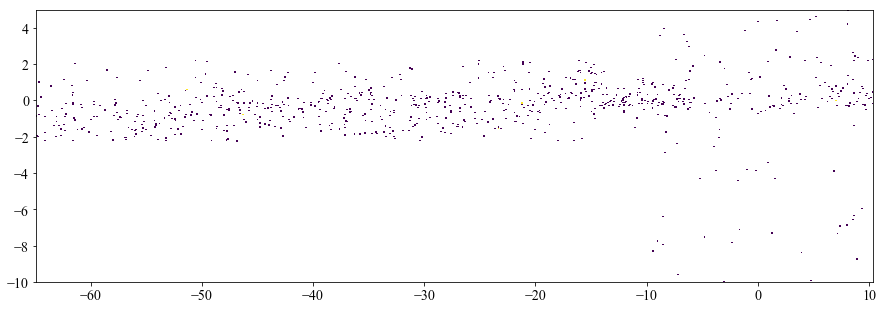

In [93]:
plt.figure(figsize=[15.,5.])
plt.hist2d((rr_together['l']-360.*(rr_together['l']>180.))[(rr_together['prob_x']>0.9)&(rr_together['class_x']=='CEP')],
           rr_together['b'][(rr_together['prob_x']>0.9)&(rr_together['class_x']=='CEP')],bins=1000,norm=LogNorm());

In [143]:
print(np.count_nonzero((rr_together['prob_nofap']>0.6)&(rr_together['class_nofap']=='RRab')))
print(np.count_nonzero((rr_together['prob_nofap']>0.6)&(rr_together['class_nofap']=='RRab')&(rr_together['b']>-100)))

112732
49557


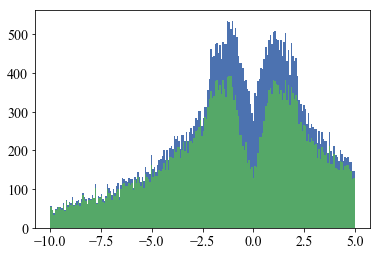

In [141]:
plt.hist(rr_together['b'][(rr_together['prob_nofap']>0.6)&(rr_together['class_nofap']=='RRab')],range=[-10,5],bins=200);
plt.hist(rr_together['b'][(rr_together['prob_nofap']>0.9)&(rr_together['class_nofap']=='RRab')],range=[-10,5],bins=200);

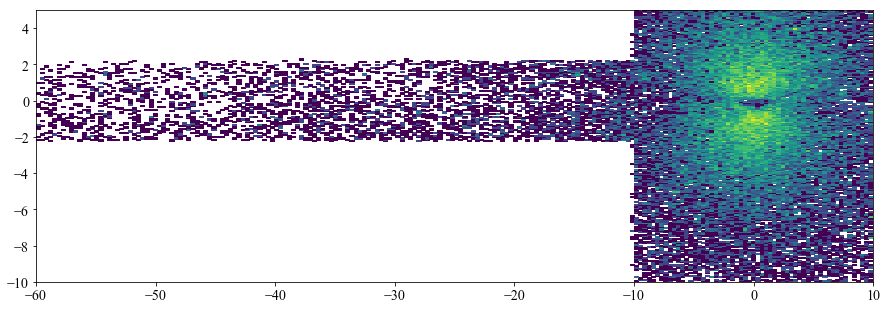

In [135]:
plt.figure(figsize=[15.,5.])
plt.hist2d((rr_together['l']-360.*(rr_together['l']>180.))[(rr_together['prob_nofap']>0.7)&(rr_together['class_nofap']=='RRab')],
           rr_together['b'][(rr_together['prob_nofap']>0.7)&(rr_together['class_nofap']=='RRab')],bins=200,norm=LogNorm(),
          range=[[-60,10],[-10,5]]);

In [ ]:
plt.figure(figsize=[15.,5.])
plt.hist2d((rr_together['l']-360.*(rr_together['l']>180.))[(rr_together['prob_nofap']>0.7)&(rr_together['class_nofap']=='RRab')],
           rr_together['b'][(rr_together['prob_nofap']>0.7)&(rr_together['class_nofap']=='RRab')],bins=200,norm=LogNorm(),
          range=[[-60,10],[-10,5]]);

## Larger RRL example

The larger sample of RRL consists of all RRab classifications with probability>0.9 using the No FAP cut classifier. The classifications using the FAP classifier are in full_data but we need to add in the extras in bigger_rrab_e

In [288]:
bigger_rrab = results_c[results_c['class_nofap']=='RRab'].reset_index(drop=True)
print(len(bigger_rrab))

706017


In [315]:
np.count_nonzero(bigger_rrab['prob_nofap']>0.9),np.count_nonzero((bigger_rrab['prob']>0.9)&(bigger_rrab['class']=='RRab'))

(40906, 38601)

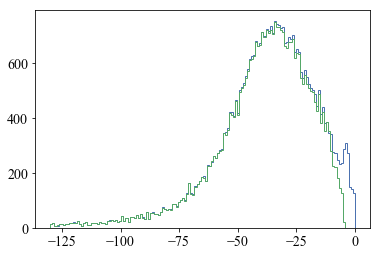

In [332]:
plt.hist(bigger_rrab['log10_fap'][bigger_rrab['prob_nofap']>0.9],bins=150,histtype='step',range=[-130,0]);
plt.hist(bigger_rrab['log10_fap'][(bigger_rrab['prob']>0.9)&(bigger_rrab['class']=='RRab')],bins=150,histtype='step',range=[-130,0]);
# plt.semilogy()

In [346]:
bigger_rrab_extra = bigger_rrab[(bigger_rrab['prob_nofap']>0.9)&(bigger_rrab['class']=='CONST')]

In [351]:
np.count_nonzero((full_data['class_nofap']=='RRab')&(full_data['prob_nofap']>0.9))+len(bigger_rrab_extra),\
np.count_nonzero((bigger_rrab['class_nofap']=='RRab')&(bigger_rrab['prob_nofap']>0.9))

(40906, 40906)

In [352]:
combined_dset_rrab_total=sqlutilpy.local_join('''
select t.sourceid,
v.astfit_epochs,v.astfit_params,v.duplicate,v.ref_epoch,v.ra,v.ra_error,v.dec,v.dec_error,v.parallax,
v.parallax_error,v.pmra,v.pmra_error,v.pmdec,v.pmdec_error,v.ra_dec_corr,v.ra_parallax_corr,v.ra_pmra_corr,
v.ra_pmdec_corr,v.dec_parallax_corr,v.dec_pmra_corr,v.dec_pmdec_corr,v.parallax_pmra_corr,v.parallax_pmdec_corr,
v.pmra_pmdec_corr,v.chisq,v.uwe,v.z_n_detections,v.z_n_observations,v.z_n_ambiguous,v.y_n_detections,v.y_n_observations,
v.y_n_ambiguous,v.j_n_detections,v.j_n_observations,v.j_n_ambiguous,v.h_n_detections,v.h_n_observations,v.h_n_ambiguous,
v.ks_n_detections,v.ks_n_observations,v.ks_n_ambiguous,v.ivw_mean_contemp_j_ks,v.ivw_mean_contemp_h_ks,v.l,v.b,
m.z_b_med_mag,m.z_b_mean_mag,m.z_b_ivw_mean_mag,m.z_b_std_mag,m.z_b_mad_mag,m.z_b_ivw_err_mag,m.z_n_b_phot,
m.y_b_med_mag,m.y_b_mean_mag,m.y_b_ivw_mean_mag,m.y_b_std_mag,m.y_b_mad_mag,m.y_b_ivw_err_mag,m.y_n_b_phot,
m.j_b_med_mag,m.j_b_mean_mag,m.j_b_ivw_mean_mag,m.j_b_std_mag,m.j_b_mad_mag,m.j_b_ivw_err_mag,m.j_n_b_phot,
m.h_b_med_mag,m.h_b_mean_mag,m.h_b_ivw_mean_mag,m.h_b_std_mag,m.h_b_mad_mag,m.h_b_ivw_err_mag,m.h_n_b_phot,
m.ks_b_med_mag,m.ks_b_mean_mag,m.ks_b_ivw_mean_mag,m.ks_b_std_mag,m.ks_b_mad_mag,m.ks_b_ivw_err_mag,m.ks_n_b_phot,
n.ks_n_epochs,n.ks_mean,n.ks_stdev,n.ks_kurtosis,n.ks_skew,n.ks_p0,n.ks_p1,n.ks_p2,n.ks_p4,n.ks_p5,n.ks_p8,
n.ks_p16,n.ks_p25,n.ks_p32,n.ks_p50,n.ks_p68,n.ks_p75,n.ks_p84,n.ks_p92,n.ks_p95,n.ks_p96,n.ks_p98,n.ks_p99,
n.ks_p100,n.ks_mad,n.ks_epoch_first,n.ks_epoch_last,n.ks_eta,n.ks_eta_e,n.ks_stetson_in,n.ks_stetson_i,
n.ks_stetson_j,n.ks_stetson_k,n.ks_ncross_m10_std,n.ks_ncross_m5_std,n.ks_ncross_m3_std,n.ks_ncross_m2_std,
n.ks_ncross_m1_std,n.ks_ncross_0_std,n.ks_ncross_1_std,n.ks_ncross_2_std,n.ks_ncross_3_std,n.ks_ncross_5_std,
n.ks_ncross_10_std,n.ks_ncross_m10_mad,n.ks_ncross_m5_mad,n.ks_ncross_m3_mad,n.ks_ncross_m2_mad,n.ks_ncross_m1_mad,
n.ks_ncross_0_mad,n.ks_ncross_1_mad,n.ks_ncross_2_mad,n.ks_ncross_3_mad,n.ks_ncross_5_mad,n.ks_ncross_10_mad
from t
inner join leigh_smith.virac2 as v on t.sourceid=v.sourceid
left join leigh_smith.virac2_photstats as m on t.sourceid=m.sourceid
inner join leigh_smith.virac2_var_indices as n on t.sourceid=n.sourceid
order by t.xid''',
't',[np.int64(bigger_rrab_extra['sourceid'].values),np.arange(len(bigger_rrab_extra)),],['sourceid','xid',],**config.wsdb_kwargs)

In [365]:
bigger_rrab_relabel_extra=relabel_table_first(bigger_rrab_extra[bigger_rrab_extra['prob_nofap']>0.9]).reset_index(drop=True)
bigger_rrab_relabel_extra = pd.merge(bigger_rrab_relabel_extra,pd.DataFrame(combined_dset_rrab_total),on='sourceid')

In [360]:
import sys
sys.path.append('../../../../')
from virac_utils import cm_gaia

gaia_dset_pd_rrl = cm_gaia(bigger_rrab_relabel_extra, epoch=2014.0, cm_radius=0.5, use_pm=True)

In [366]:
gaia_columns = ['source_id','ra','dec','parallax','pmra','pmdec',
                'parallax_error','pmra_error','pmdec_error',
                'parallax_pmra_corr','parallax_pmdec_corr','pmra_pmdec_corr',
                'phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag',
                'ruwe']

for c in gaia_columns:
    bigger_rrab_relabel_extra['gaia_edr3_'+c] = gaia_dset_pd_rrl[c]
bigger_rrab_relabel_extra['virac2_gedr3_sep'] = gaia_dset_pd_rrl['q3c_dist']
bigger_rrab_relabel_extra['ebv_schlegel'] = gaia_dset_pd_rrl['ebv']
bigger_rrab_relabel_extra=relabel_combined(bigger_rrab_relabel_extra)

In [373]:
len(full_data_rrl.columns), len(full_data.columns)

(179, 179)

In [372]:
del bigger_rrab_relabel_extra['j_ks_0']
del bigger_rrab_relabel_extra['h_ks_0']

full_data_rrl = pd.concat([full_data[(full_data['class_nofap']=='RRab')&(full_data['prob_nofap']>0.9)], bigger_rrab_relabel_extra], axis=0, sort=False)

cc = rr.columns.copy()[:-1]
full_data_rrl = full_data_rrl[np.concatenate([cc,['class_nofap', 'prob_nofap', 'prob_var', 'prob_var_nofap']])]
full_data_rrl['sourceid']=full_data_rrl['sourceid'].astype(np.int64)
full_data_rrl['significant_second_minimum']=full_data_rrl['significant_second_minimum'].astype(bool)
full_data_rrl['ks_stetson_j']/=(full_data_rrl['ks_varstats_n_epochs']-1)

In [379]:
ogle4_rrl=pd.DataFrame(sqlutilpy.get('''select * from ogle4_rrl_bulge_disc''', 
                                     **config.wsdb_kwargs))
from astropy.coordinates import SkyCoord
import astropy.units as u
ogle_skycoord = SkyCoord(ra=ogle4_rrl['ra']*u.deg, dec=ogle4_rrl['decl']*u.deg, 
                         frame='icrs').transform_to('galactic')

In [411]:
ogg = pd.read_csv('/data/jls/virac/o4rrab_bulge+disk_gpr_param.dat',sep=r'\s+')
ogg = ogg[['id','period','totamp','A1','A2','A3','phi21','phi31','phi31v','phi31Kp']]

ogg = ogg.rename(columns = {'period':'period_ogle',
                            'totamp':'i_model_amplitude_dekany',
                            'A1':'i_amp1_dekany',
                            'A2':'i_amp2_dekany',
                            'A3':'i_amp3_dekany',
                            'phi21':'i_phi21_dekany',
                            'phi31':'i_phi31_dekany',
                            'phi31v':'v_phi31',
                            'phi31Kp':'Kp_phi31'})


In [466]:
def renamer(s):
    p=s.split('-RRLYR-')
    return {'OGLE-BLG':'b','OGLE-SMC':'s','OGLE-LMC':'l','OGLE-GD':'d'}[p[0]]+p[1]
ogle4_rrl_redux = ogle4_rrl[['id','ra','decl','type','a_1','dp_1','r21_1','r31_1','phi21_1','phi31_1']]
ogle4_rrl_redux = ogle4_rrl_redux.rename(columns = {'id':'ogle_id','ra':'ogle_ra','decl':'ogle_dec','type':'ogle_type',
                                                    'a_1':'i_model_amplitude_ogle','dp_1':'period_error_ogle',
                                                    'r21_1':'i_amp2_amp1_ogle',
                                                    'r31_1':'i_amp3_amp1_ogle',
                                                    'phi21_1':'i_phi21_ogle',
                                                    'phi31_1':'i_phi31_ogle'})

ogle4_rrl_redux['id_dekany']=[renamer(ogle4_rrl_redux['ogle_id'][s]) for s in range(len(ogle4_rrl_redux))]
ogle = pd.merge(ogle4_rrl_redux, ogg, left_on='id_dekany', right_on='id')
del ogle['id_dekany']
del ogle['id']

In [425]:
c = SkyCoord(ra=(full_data_rrl['ra'].values*u.degree-15.*u.yr*full_data_rrl['pmra'].values*u.mas/u.yr/np.cos(np.deg2rad(full_data_rrl['dec'].values))), 
             dec=(full_data_rrl['dec'].values*u.degree-15.*u.yr*full_data_rrl['pmdec'].values*u.mas/u.yr),frame='icrs')
catalog = SkyCoord(ra=ogle['ogle_ra'].values*u.deg, dec=ogle['ogle_dec'].values*u.deg,frame='icrs')
idx, d2d, d3d = c.match_to_catalog_sky(catalog)
idx_ogle, d2d_ogle, d3d_ogle = catalog.match_to_catalog_sky(c)

In [467]:
full_data_rrl_ogle = pd.concat([
                pd.concat([full_data_rrl[d2d.arcsec<=0.4].reset_index(drop=True), 
                           ogle.iloc[idx[d2d.arcsec<=0.4]].reset_index(drop=True)],axis=1),
                full_data_rrl[d2d.arcsec>0.4].reset_index(drop=True)],axis=0,sort=False).reset_index(drop=True)

In [576]:
np.unique(full_data_rrl_ogle['ogle_type'][full_data_rrl_ogle['ogle_type']==full_data_rrl_ogle['ogle_type']])

array(['RRab'], dtype=object)

In [474]:
sqlutilpy.upload('virac2_rrab',
             [fmtr(full_data_rrl_ogle,s,[0,100000]) for s in full_data_rrl_ogle.keys()],
             full_data_rrl_ogle.keys(),createTable=True,
             **wsdb_upload_kwargs)

In [ ]:
plt.plot(bigger_rrab['period'][bigger_rrab['prob_nofap']>0.9],
        bigger_rrab['mo'][bigger_rrab['prob_nofap']>0.9])

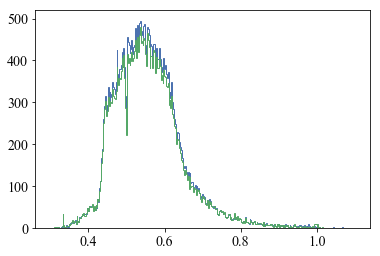

In [333]:
plt.hist(bigger_rrab['period'][bigger_rrab['prob_nofap']>0.9],bins=350,histtype='step',range=[0.3,1.1]);
plt.hist(bigger_rrab['period'][(bigger_rrab['prob']>0.9)&(bigger_rrab['class']=='RRab')],bins=350,histtype='step',range=[0.3,1.1]);
# plt.semilogy()

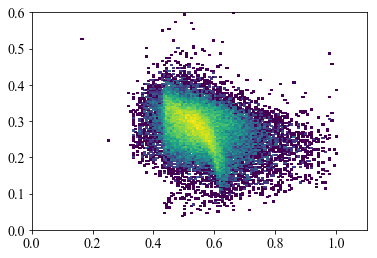

In [343]:
plt.hist2d(bigger_rrab['period'][bigger_rrab['prob_nofap']>0.95],
        bigger_rrab['model_amplitude'][bigger_rrab['prob_nofap']>0.95],
           range=[[0.,1.1],[0.,0.6]],bins=150,norm=LogNorm());

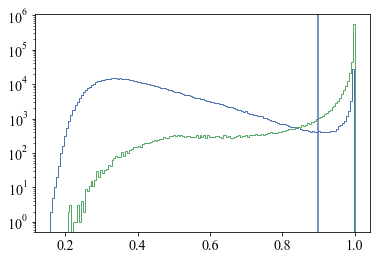

In [324]:
plt.hist(bigger_rrab['prob_nofap'],bins=150,histtype='step');
plt.hist(bigger_rrab['prob'],bins=150,histtype='step');
plt.semilogy()
plt.axvline(0.9)

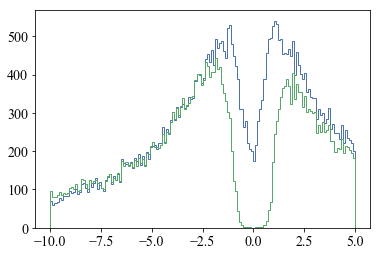

In [491]:
fs = (full_data_rrl_ogle['l']<10.)|(full_data_rrl_ogle['l']>350.)
plt.hist(full_data_rrl_ogle['b'][fs],range=[-10,5],bins=150,histtype='step',
         weights=1./0.89*np.ones_like(full_data_rrl_ogle['b'][fs]));
fs = (ogle_skycoord.galactic.l.deg<10.)|(ogle_skycoord.galactic.l.deg>350.)
plt.hist(ogle_skycoord.galactic.b.deg[(ogle4_rrl['type']=='RRab')&fs],range=[-10,5],bins=150,histtype='step');

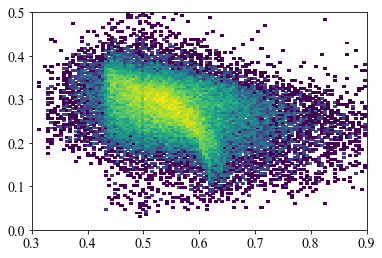

In [516]:
plt.hist2d(full_data_rrl['period'],full_data_rrl['ks_lsq_amplitude'],
          range=[[0.3,0.9],[0.,0.5]],bins=110,norm=LogNorm());

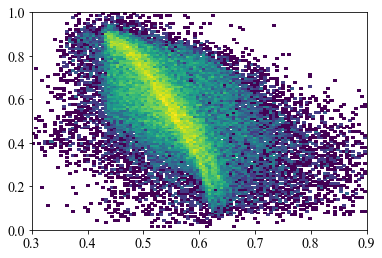

In [515]:
plt.hist2d(ogle4_rrl['p_1'][(ogle4_rrl['type']=='RRab')&fs],ogle4_rrl['a_1'][(ogle4_rrl['type']=='RRab')&fs],
          range=[[0.3,0.9],[0.,1.]],bins=110,norm=LogNorm());
# plt.plot(full_data_rrl_ogle['period_ogle'],full_data_rrl_ogle['i_model_amplitude_ogle'],'.',ms=0.5)

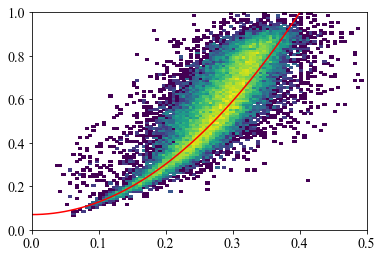

In [538]:
plt.hist2d(full_data_rrl_ogle['ks_lsq_amplitude'],full_data_rrl_ogle['i_model_amplitude_dekany'],
          range=[[0.,0.5],[0.,1.]],bins=100,norm=LogNorm());
xx = np.linspace(0.,0.4)
plt.plot(xx,5.8*xx**2+0.07,color='r')

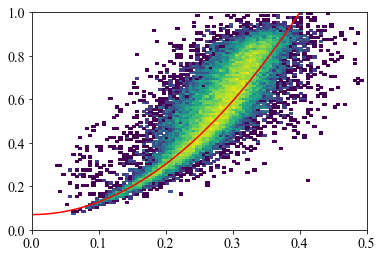

In [537]:
plt.hist2d(full_data_rrl_ogle['ks_lsq_amplitude'],full_data_rrl_ogle['i_model_amplitude_ogle'],
          range=[[0.,0.5],[0.,1.]],bins=100,norm=LogNorm());
xx = np.linspace(0.,0.4)
plt.plot(xx,5.8*xx**2+0.07,color='r')

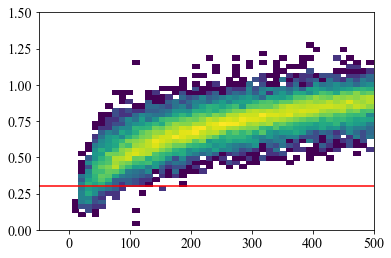

In [602]:
plt.hist2d(full_data_rrl_ogle['delta_logl_lsq_const'],
          np.log10(full_data_rrl_ogle['ks_lsq_amplitude']/
           (np.sqrt(full_data_rrl_ogle['ks_n_detections'])*full_data_rrl_ogle['ks_ivw_err_mag'])),
           range=[[-50.,500.],[0.,1.5]],
           bins=50,norm=LogNorm());
plt.axhline(np.log10(2.),color='r')

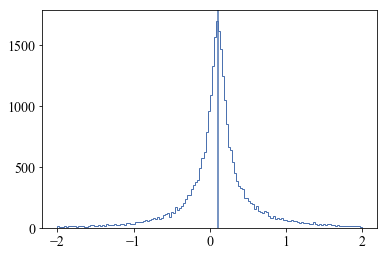

In [621]:
plt.hist(full_data_rrl_ogle['gaia_edr3_parallax'],range=[-2,2.],bins=150,histtype='step');
plt.axvline(1./9.18)
# plt.hist(full_data_rrl_ogle['pmdec'],range=[-20,10.],bins=150,histtype='step');

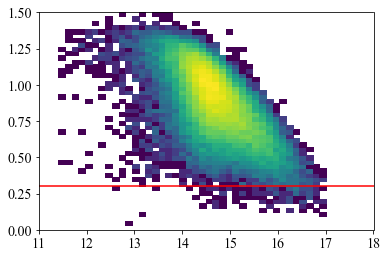

In [594]:
plt.hist2d(full_data_rrl_ogle['ks_ivw_mean_mag'],
          np.log10(full_data_rrl_ogle['ks_lsq_amplitude']/
           (np.sqrt(full_data_rrl_ogle['ks_n_detections'])*full_data_rrl_ogle['ks_ivw_err_mag'])),
           range=[[11.,18.],[0.,1.5]],
           bins=50,norm=LogNorm());
plt.axhline(np.log10(2.),color='r')

In [558]:
full_data_rrl_ogle['ogle_type'].values[-1]==np.nan

False

In [560]:
np.unique(ogle4_rrl['type'])

array(['RRab', 'RRc', 'RRd', 'aRRd'], dtype=object)

In [563]:
np.count_nonzero((full_data_rrl_ogle['ogle_type']=='aRRd'))

0

In [548]:
np.count_nonzero(full_data_rrl_ogle['i_phi31_dekany']>0.),\
np.count_nonzero(full_data_rrl_ogle['i_phi31_ogle']>0.),\
len(full_data_rrl_ogle)

(27359, 27080, 40906)

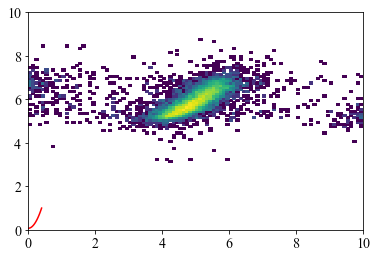

In [544]:
plt.hist2d(full_data_rrl_ogle['lsq_phi_3']-3*full_data_rrl_ogle['lsq_phi_1'],full_data_rrl_ogle['i_phi31_dekany'],
          range=[[0.,10.],[0.,10.]],bins=100,norm=LogNorm());
xx = np.linspace(0.,0.4)
plt.plot(xx,5.8*xx**2+0.07,color='r')

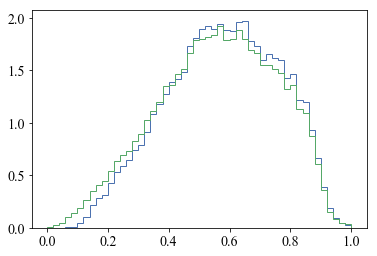

In [504]:
plt.hist(full_data_rrl_ogle['i_model_amplitude_ogle'],bins=50,histtype='step',range=[0,1],density=True)
plt.hist(ogle4_rrl['a_1'][(ogle4_rrl['type']=='RRab')&fs],bins=50,histtype='step',range=[0,1],density=True);